In [1]:
# ch2/ch2_1_grid_sarma/grid_sarima.ipynb
# 标准库
import sys
import warnings
from itertools import product

# 第三方模块
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

# 自定义模块
sys.path.append('./../../')
import utils.dataset as udataset
import utils.metrics as umetrics
import utils.plot as uplot

# 忽略模型拟合警告
warnings.filterwarnings('ignore')

# 绘图参数
name_model = 'GRID_SARIMA'
name_var = '乘客数量'
name_unit = ''
uplot.set_matplotlib(plot_dpi=80, save_dpi=600, font_size=12)


,序列长度,最大值,最小值,均值,标准差,偏度,峰度
0,144,622,104,280.3,119.97,0.58,-0.36


data.shape=(144, 1)
train.shape=(120, 1), test.shape=(24, 1)


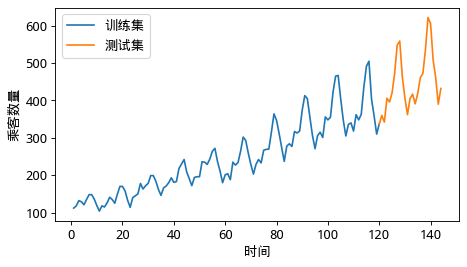

In [2]:
# 数据读取
data = pd.read_csv('./data/data_passengers.csv', parse_dates=['Month'])
data = data.set_index('Month')
udataset.stats(data.values)
print(f'{data.shape=}')

# 训练测试划分
num_train = 120
train = data.iloc[:num_train]
test = data.iloc[num_train:]
print(f'{train.shape=}, {test.shape=}')

# 可视化
uplot.plot_dataset(
    train.values,
    test.values,
    xlabel='时间',
    ylabel=f'{name_var}{name_unit}',
    fig_name=f'原始序列_{name_model}'
)


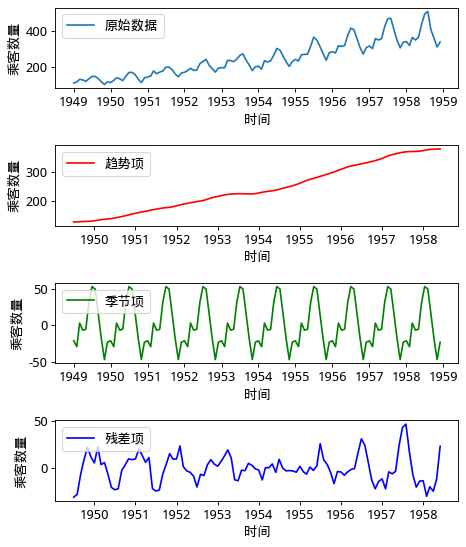

In [3]:
# 季节性分解
decomposition = seasonal_decompose(
    train,  # 时间序列
    model='addictive',  # 季节分量类型
)

# 季节性分解可视化
uplot.plot_decomposition(
    series=train,
    decomposition=decomposition,
    xlabel='时间',
    ylabel=f'{name_var}{name_unit}',
    fig_name=f'季节分解_{name_model}'
)


差分次数d=0: 接受原假设H0, 序列有单位根, 序列不平稳, 需要差分
差分次数d=1: 接受原假设H0, 序列有单位根, 序列不平稳, 需要差分
差分次数d=2: 拒绝原假设H0, 序列没有单位根, 序列平稳
平稳差分次数order_diff=2
拒绝原假设H0, 序列为非白噪声
拒绝原假设H0, 序列为非白噪声
拒绝原假设H0, 序列为非白噪声


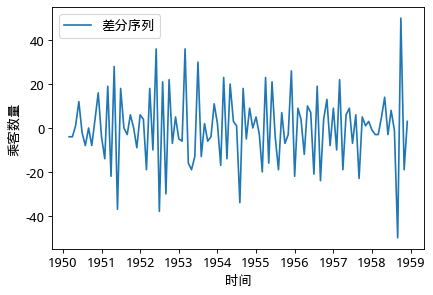

In [4]:
# 序列预处理
train_diff = train.copy(deep=True)

# 最大差分次数
max_d = 3

# 平稳性检验, 不通过则差分
for d in range(0, max_d):

    # 平稳性检验/ADF检验
    # H0 原假设: 存在单位根，序列不平稳
    # H1 备选假设: 不存在单位根，序列平稳
    adftest = adfuller(train_diff)
    pvalue = adftest[1]
    if pvalue < 0.05:
        print(f'差分次数{d=}: 拒绝原假设H0, 序列没有单位根, 序列平稳')
        order_diff = d
        break
    else:
        print(f'差分次数{d=}: 接受原假设H0, 序列有单位根, 序列不平稳, 需要差分')
        # 差分序列
        train_diff = train_diff.diff(periods=1)
        train_diff.dropna(inplace=True)

print(f'平稳差分次数{order_diff=}')

# 去除季节性
train_diff = train_diff.diff(12)
train_diff.dropna(inplace=True)

# 差分序列白噪声检验/ljungbox检验
# H0 原假设: 序列为白噪声
# H1 备选假设: 序列为非白噪声
ljungboxtest = acorr_ljungbox(train_diff, lags=[6, 12, 18], return_df=True)
pvalues = ljungboxtest['lb_pvalue'].values
for pvalue in pvalues:
    if pvalue < 0.05:
        print('拒绝原假设H0, 序列为非白噪声')
    else:
        print('接受原假设H0, 序列为白噪声, 终止分析')
        break

# 差分序列可视化
plt.plot(train_diff, label='差分序列')
plt.legend(loc='upper left')
plt.xlabel('时间')
plt.ylabel(f'{name_var}{name_unit}')
plt.savefig(f'./fig/差分序列_{name_model}.jpg', bbox_inches='tight')
plt.show()


In [5]:
# 使用BIC准则搜索最优参数组合

# 搜索上限
max_value = 3

# ARIMA参数
p = range(max_value)
d = order_diff
q = range(max_value)

# 季节项参数
P = range(max_value)
D = 1
Q = range(max_value)
S = 12

# SARIMA参数网格构建
param_grid = product(p, q, P, Q)
param_grid = list(param_grid)
print(f'待搜索参数数量:{len(param_grid)=}')


待搜索参数数量:len(param_grid)=81


In [6]:
# 全部搜索结果
results = []

# 最优BIC值
best_bic = float('inf')

# 遍历搜索
for param in tqdm(param_grid):

    # 参数获取
    p, q, P, Q = param

    # 以当前参数组合拟合SARIMA模型
    try:
        model = SARIMAX(
            train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, S)
        ).fit(disp=-1)
    except Exception:
        continue

    # 模型BIC值
    bic = model.bic

    # 寻找最优的参数
    if bic < best_bic:
        best_bic = bic
        best_model = model
        best_param = param

    # 追加本次搜索结果
    results.append([param, bic])

# 重构搜索结果
results = pd.DataFrame(
    results,
    columns=['parameters', 'bic']
)

# 搜索结果排序
results = results.sort_values(
    by='bic',
    ascending=True
).reset_index(drop=True)

# 获取最优超参数
p, q, P, Q = best_param

# 参数搜索
print(f'最优参数:{p=}, {d=}, {q=}, {P=}, {D=}, {Q=}, {S=}, 最优BIC:{best_bic:.2f}')

# 最优模型执行预测
pred = best_model.forecast(test.shape[0])

# 误差评价
umetrics.all_metrics(test.values, pred.values)


100%|██████████| 81/81 [00:37<00:00,  2.17it/s]

最优参数:p=1, d=2, q=1, P=0, D=1, Q=0, S=12, 最优BIC:811.89
mse=5576.015
rmse=74.673
mae=68.950
mape=15.009%
sde=28.670
r2=0.000
pcc=0.929


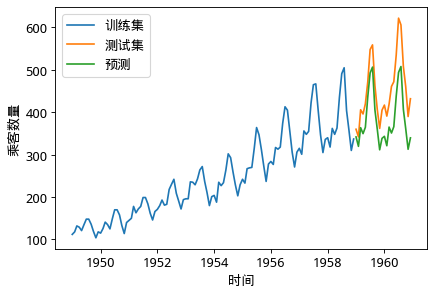

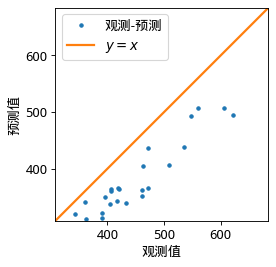

In [7]:
# 可视化
plt.plot(train, label='训练集')
plt.plot(test, label='测试集')
plt.plot(pred, label='预测')
plt.legend(loc='upper left')
plt.xlabel('时间')
plt.ylabel(f'{name_var}{name_unit}')
plt.savefig(f'./fig/预测结果_{name_model}.jpg', bbox_inches='tight')
plt.show()

uplot.plot_parity(
    y_true=test.values,
    y_pred=pred.values,
    xlabel=f'观测值{name_unit}',
    ylabel=f'预测值{name_unit}',
    fig_name=f'{name_model}_Parity'
)